In [2]:
# HIDDEN 

from datascience import *
import numpy as np

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Comparing Two Groups

In the examples above, we investigated whether a sample appears to be chosen randomly from an underlying population. We did this by comparing the distribution of the sample with the distribution of the population. A similar line of reasoning can be used to compare the distributions of two samples. In particular, we can investigate whether or not two samples appear to be drawn from the same underlying distribution.

### Example: Married Couples and Unmarried Partners

Our next example is based on a study conducted in 2010 under the auspices of the National Center for Family and Marriage Research. 

In the United States, the proportion of couples who live together but are not married has been rising in recent decades. The study involved a national random sample of over 1,000 heterosexual couples who were either married or "cohabiting partners" – living together but unmarried. One of the goals of the study was to compare the attitudes and experiences of the married and unmarried couples. 

The table below shows a subset of the data collected in the study. Each row corresponds to one person. The variables that we will examine in this section are:

- Marital Status: married or unmarried
- Employment Status: one of several categories described below
- Gender
- Age: Age in years


In [3]:
columns = ['Marital Status', 'Employment Status', 'Gender', 'Age', ]
couples = Table.read_table('couples.csv').select(columns)
couples

Marital Status | Employment Status        | Gender | Age
married        | working as paid employee | male   | 51
married        | working as paid employee | female | 53
married        | working as paid employee | male   | 57
married        | working as paid employee | female | 57
married        | working as paid employee | male   | 60
married        | working as paid employee | female | 57
married        | working, self-employed   | male   | 62
married        | working as paid employee | female | 59
married        | not working - other      | male   | 53
married        | not working - retired    | female | 61
... (2056 rows omitted)

Let us consider just the males first. There are 742 married couples and 292 unmarried couples, and all couples in this study had one male and one female, making 1,034 males in all. 

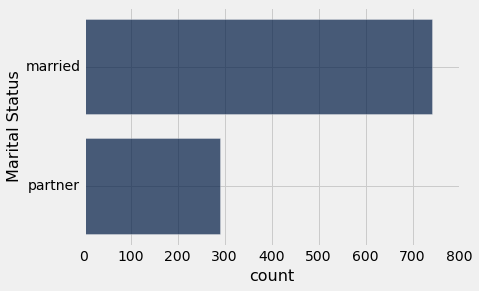

In [4]:
# Separate tables for married and cohabiting unmarried couples:

married_men = couples.where('Gender', 'male').where('Marital Status', 'married')
partnered_men = couples.where('Gender', 'male').where('Marital Status', 'partner')

# Let's see how many married and unmarried people there are:
couples.where('Gender', 'male').group('Marital Status').barh("Marital Status")

Societal norms have changed over the decades, and there has been a gradual acceptance of couples living together without being married. Thus it is natural to expect that unmarried couples will in general consist of younger people than married couples. 

The histograms of the ages of the married and unmarried men show that this is indeed the case. We will draw these histograms and compare them. In order to compare two histograms, both should be drawn to the same scale. Let us write a function that does this for us.

In [63]:
def plot_age(table, subject):
    """
    Draws a histogram of the Age column in the given table.
    
    table should be a Table with a column of people's ages called Age.
    
    subject should be a string -- the name of the group we're displaying,
    like "married men".
    """
    # Draw a histogram of ages running from 15 years to 70 years
    table.hist('Age', bins=np.arange(15, 71, 5), unit='year')
    # Set the lower and upper bounds of the vertical axis so that
    # the plots we make are all comparable.
    plt.ylim(0, 0.045)
    plt.title("Ages of " + subject)

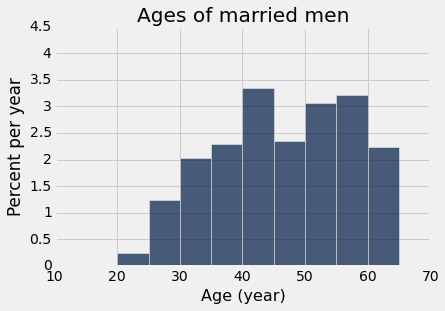

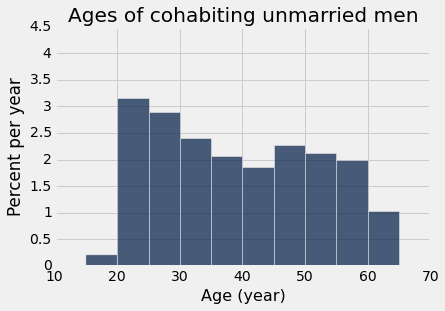

In [65]:
# Ages of men:
plot_age(married_men, "married men")
plot_age(partnered_men, "cohabiting unmarried men")

The difference is even more marked when we compare the married and unmarried women.

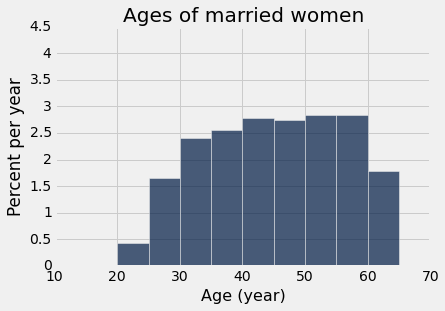

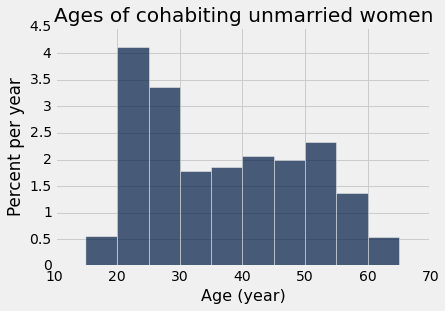

In [67]:
married_women = couples.where('Gender', 'female').where('Marital Status', 'married')
partnered_women = couples.where('Gender', 'female').where('Marital Status', 'partner')

# Ages of women:
plot_age(married_women, "married women")
plot_age(partnered_women, "cohabiting unmarried women")

The histograms show that the married men in the sample are in general older than unmarried cohabiting men. Married women are in general older than unmarried women. These observations are consistent with what we had predicted based on changing social norms. 

If married couples are in general older, they might differ from unmarried couples in other ways as well. Let us compare the employment status of the married and unmarried men in the sample.

The table below shows the marital status and employment status of each man in the sample.

In [8]:
males = couples.where('Gender', 'male').select(['Marital Status', 'Employment Status'])
males.show(5)

### Contingency Tables

To investigate the association between employment and marriage, we would like to be able to ask questions like, "How many married men are retired?"

Recall that the method `pivot` lets us do exactly that. It *cross-classifies* each man according to the two variables – marital status and employment status. Its output is a *contingency table* that contains the counts in each pair of categories. 

In [18]:
employment = males.pivot('Marital Status', 'Employment Status')
employment

Employment Status                              | married | partner
not working - disabled                         | 44      | 20
not working - looking for work                 | 28      | 33
not working - on a temporary layoff from a job | 15      | 8
not working - other                            | 16      | 9
not working - retired                          | 44      | 4
working as paid employee                       | 513     | 170
working, self-employed                         | 82      | 47

The arguments of `pivot` are the labels of the two columns corresponding to the variables we are studying. Categories of the first argument appear as columns; categories of the second argument are the rows.  Each cell of the table contains the number of men in a pair of categories – a particular employment status and a particular marital status.

The table shows that regardless of marital status, the men in the sample are most likely to be working as paid employees. But it is quite hard to compare the entire distributions based on this table, because the numbers of married and unmarried men in the sample are not the same. There are 742 married men but only 291 unmarried ones.

In [19]:
employment.drop(0).sum()

married | partner
742     | 291

To adjust for this difference in total numbers, we will convert the counts into proportions, by dividing all the ``married`` counts by 742 and all the ``partner`` counts by 291.

In [20]:
proportions = Table().with_columns([
        "Employment Status", cc.column("Employment Status"),
        "married", employment.column('married')/sum(employment.column('married')),
        "partner", employment.column('partner')/sum(employment.column('partner'))
    ])
proportions.show()

The ``married`` column of this table shows the distribution of employment status of the married men in the sample. For example, among married men, the proportion who are retired is about 0.059. The ``partner`` column shows the distribution of the employment status of the unmarried men in the sample. Among unmarried men, the proportion who are retired is about 0.014.

The two distributions look different from each other in other ways too, as can be seen more clearly in the bar graphs below. It appears that a larger proportion of the married men in the sample work as paid employees, whereas a larger proportion of the unmarried men are not working but are looking for work.

In [14]:
proportions.barh('Employment Status')

The distributions of employment status of the men in the two groups – married and unmarried – is clearly different in the sample.

### Are the two distributions different in the population?

This raises the question of whether the difference is due to randomness in the sampling, or whether the distributions of employment status are indeed different for married and umarried cohabiting men in the U.S. Remember that the data that we have are from a sample of just 1,033 couples; we do not know the distribution of employment status of married or unmarried cohabiting men in the entire country.

We can answer the question by performing a statistical test of hypotheses. Let us use the terminology that we developed for this in the previous section.

**Null hypothesis.** In the United States, the distribution of employment status among married men is the same as among unmarried men who live with their partners. 

Another way of saying this is that employment status and marital status are *independent* or *not associated*.

If the null hypothesis were true, then the difference that we have observed in the sample would be just due to chance.

**Alternative hypothesis.** In the United States, the distributions of the employment status of the two groups of men are different. In other words, employment status and marital status are associated in some way.

As our **test statistic**, we will use the total variation distance between two distributions. 

The observed value of the test statistic is about 0.15:

In [25]:
# TVD between the two distributions in the sample
married = proportions.column('married')
partner = proportions.column('partner')
observed_tvd = 0.5*sum(abs(married - partner))
observed_tvd

0.15273571011754242

### Random Permutations

In order to compare this observed value of the total variation distance with what is predicted by the null hypothesis, we need to know how the total variation distance would vary across all possible random samples if employment status and marital status were not related.

This is quite daunting to derive by mathematics, but let us see if we can get a good approximation by simulation.  

With just one sample at hand, and no further knowledge of the distribution of employment status among men in the United States, how can we go about replicating the sampling procedure? The key is to note that *if* marital status and employment status were not connected in any way, then we could replicate the sampling process by replacing each man's employment status by a randomly picked employment status from among all the men, married and unmarried. 

Doing this for all the men is equivalent to randomly rearranging the entire column containing employment status, while leaving the marital status column unchanged. Such a rearrangement is called a *random permutation*.

Thus, under the null hypothesis, we can replicate the sampling process by assigning to each man an employment status chosen at random without replacement from the entries in the column `Employment Status`. We can do the replication by simply permuting the entire `Employment Status` column and leaving everything else unchanged.

Let's implement this plan. First, we will shuffle the column `empl_status` using the `sample` method, which just shuffles all the rows when provided with no arguments.

In [21]:
# Randomly permute the employment status of all men

shuffled = males.select('Employment Status').sample()
shuffled

Employment Status
working, self-employed
working, self-employed
working as paid employee
working as paid employee
working, self-employed
working as paid employee
not working - disabled
working as paid employee
working as paid employee
working as paid employee
... (1023 rows omitted)

The first two columns of the table below are taken from the original sample. The third has been created by randomly permuting the original `Employment Status` column. 

In [23]:
# Construct a table in which employment status has been shuffled

males_with_shuffled_empl = Table().with_columns([
        "Marital Status", males.column('Marital Status'),
        "Employment Status", males.column('Employment Status'),
        "Employment Status (shuffled)", shuffled.column('Employment Status')
    ])
males_with_shuffled_empl

Marital Status | Employment Status                              | Employment Status (shuffled)
married        | working as paid employee                       | working, self-employed
married        | working as paid employee                       | working, self-employed
married        | working as paid employee                       | working as paid employee
married        | working, self-employed                         | working as paid employee
married        | not working - other                            | working, self-employed
married        | not working - on a temporary layoff from a job | working as paid employee
married        | not working - disabled                         | not working - disabled
married        | working as paid employee                       | working as paid employee
married        | working as paid employee                       | working as paid employee
married        | not working - retired                          | working as paid employee
... (1023 rows omitted)

Once again, the ``pivot`` method computes the contingency table, which allows us to calculate the total variation distance between the distributions of the two groups of men after their employment status has been shuffled.

In [28]:
employment_shuffled = males_with_shuffled_empl.pivot('Marital Status', 'Employment Status (shuffled)')
employment_shuffled

Employment Status (shuffled)                   | married | partner
not working - disabled                         | 48      | 16
not working - looking for work                 | 44      | 17
not working - on a temporary layoff from a job | 16      | 7
not working - other                            | 18      | 7
not working - retired                          | 39      | 9
working as paid employee                       | 489     | 194
working, self-employed                         | 88      | 41

In [32]:
# TVD between the two distributions in the contingency table above
e_s = employment_shuffled
married = e_s.column('married')/sum(e_s.column('married'))
partner = e_s.column('partner')/sum(e_s.column('partner'))
0.5*sum(abs(married - partner))

0.032423745611841297

This total variation distance was computed based on the null hypothesis that the distributions of employment status for the two groups of men are the same. You can see that it is noticeably smaller than the observed value of the total variation distance (0.15) between the two groups in our original sample. 

### A Permutation Test

Could this just be due to chance variation? We will only know if we run many more replications, by randomly permuting the ``Employment Status`` column repeatedly. This method of testing is known as a **permutation test**.

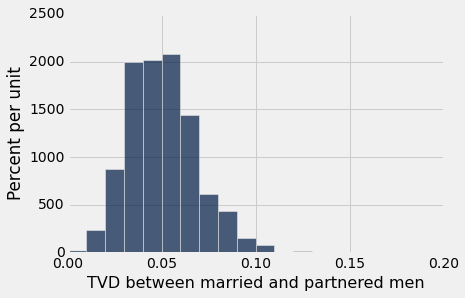

In [51]:
# Put it all together in a for loop to perform a permutation test

repetitions = 500

tvds = Table().with_column("TVD between married and partnered men", [])

for i in np.arange(repetitions):
    # Construct a permuted table
    shuffled = males.select('Employment Status').sample()
    combined = Table().with_columns([
            "Marital Status", males.column('Marital Status'),
            "Employment Status", shuffled.column('Employment Status')
        ])
    employment_shuffled = combined.pivot('Marital Status', 'Employment Status')
    
    # Compute TVD
    e_s = employment_shuffled
    married = e_s.column('married')/sum(e_s.column('married'))
    partner = e_s.column('partner')/sum(e_s.column('partner'))
    permutation_tvd = 0.5*sum(abs(married - partner))
    tvds.append([permutation_tvd])

tvds.hist(bins=np.arange(0, 0.2, 0.01))

The figure above is the **empirical distribution of the total variation distance** between the distributions of the employment status of married and unmarried men, under the null hypothesis. 

**The observed test statistic of 0.15 is quite far in the tail, and so the chance of observing such an extreme value under the null hypothesis is close to 0**. 

As before, this chance is called an empirical P-value. The P-value is the chance that our test statistic (TVD) would come out at least as extreme as the observed value (in this case 0.15 or greater) under the null hypothesis.  

### Conclusion of the test

Our empirical estimate based on repeated sampling gives us all the information we need for drawing conclusions from the data: the observed statistic is very unlikely under the null hypothesis. 

The low P-value constitutes **evidence in favor of the alternative hypothesis**. The data support the hypothesis that in the United States, the distribution of the employment status of married men is not the same as that of unmarried men who live with their partners.

We have just completed our first *permutation test*. Permutation tests are quite common in practice because they make very few assumptions about the underlying population and are straightforward to perform and interpret.

**Note about the approximate P-value**

Our simulation gives us an approximate empirical P-value, because it is based on just 500 random permutations instead of all the possible random permutations. We can compute this empirical P-value directly, without drawing the histogram:

In [42]:
empirical_p_value = np.count_nonzero(tvds.column(0) >= observed_tvd) / tvds.num_rows
empirical_p_value

0.0

Computing the exact P-value would require us to consider all possible outcomes of shuffling (which is very large) instead of 500 random shuffles. If we had performed all the random shuffles, there would have been a few with more extreme TVDs. The true P-value is greater than zero, but not by much.

### Generalizing Our Hypothesis Test

The example above includes a substantial amount of code in order to investigate the relationship between two characteristics (marital status and employment status) for a particular subset of the surveyed population (males). Suppose we would like to investigate different characteristics or a different population. How can we reuse the code we have written so far in order to explore more relationships?

When you are about to copy your code, you should think, "Maybe I should write some functions."

What functions to write? A good way to make this decision is to think about what you have to compute repeatedly. 

In our example, the total variation distance is computed over and over again. So we will begin with a generalized computation of total variation distance between the distribution of any column of values (such as employment status) when separated into any two conditions (such as marital status) for a collection of data described by any table. Our implementation includes the same statements as we used above, but uses generic names that are specified by the final function call.

In [36]:
# TVD between the distributions of values under any two conditions

def tvd(t, conditions, values):
    """Compute the total variation distance 
    between proportions of values under two conditions.
    
    t          (Table) -- a table
    conditions (str)   -- a column label in t; should have only two categories
    values     (str)   -- a column label in t
    """
    e = t.pivot(conditions, values)
    a = e.column(1)
    b = e.column(2)
    return 0.5*sum(abs(a/sum(a) - b/sum(b)))

tvd(males, 'Marital Status', 'Employment Status')

0.15273571011754242

Next, we can write a function that performs a permutation test using this `tvd` function to compute the same statistic on shuffled variants of any table. It's worth reading through this implementation to understand its details. 

In [55]:
def permutation_tvd(original, conditions, values):
    """
    Perform a permutation test of whether 
    the distribution of values for two conditions 
    is the same in the population,
    using the total variation distance between two distributions
    as the test statistic.
    
    original is a Table with two columns.  The value of the argument
    conditions is the name of one column, and the value of the argument
    values is the name of the other column.  The conditions table should
    have only 2 possible values corresponding to 2 categories in the
    data.
    
    The values column is shuffled many times, and the data are grouped
    according to the conditions column.  The total variation distance
    between the proportions values in the 2 categories is computed.  
    
    Then we draw a histogram of all those TV distances.  This shows us 
    what the TVD between the values of the two distributions would typically
    look like if the values were independent of the conditions.
    """
    repetitions = 500
    stats = []

    for i in np.arange(repetitions):
        shuffled = original.sample()
        combined = Table().with_columns([
                conditions, original.column(conditions),
                values, shuffled.column(values)
            ])
        stats.append(tvd(combined, conditions, values))

    observation = tvd(original, conditions, values)
    p_value = np.count_nonzero(stats >= observation) / repetitions
    
    print("Observation:", observation)
    print("Empirical P-value:", p_value)
    Table([stats], ['Empirical distribution']).hist()

Observation: 0.152735710118
Empirical P-value: 0.0


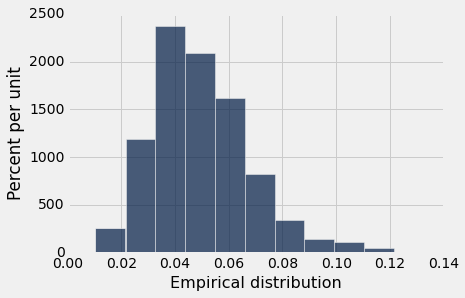

In [56]:
permutation_tvd(males, 'Marital Status', 'Employment Status')

Now that we have generalized our permutation test, we can apply it to other hypotheses. For example, we can compare the distribution over the employment status of women, grouping them by their marital status. In the case of men we found a difference, but what about with women? First, we can visualize the two distributions. 

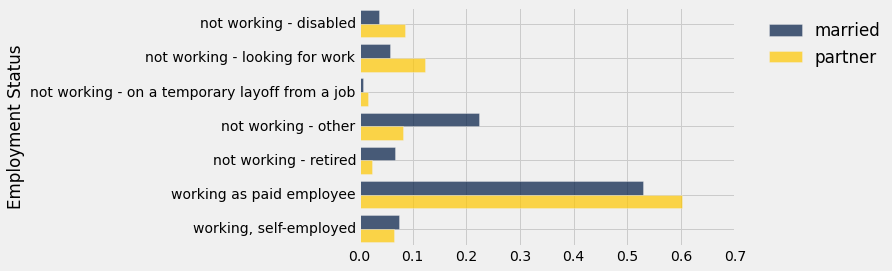

In [40]:
def compare_bar(t, conditions, values):
    """Bargraphs of distributions of values for each of two conditions."""
    e = t.pivot(conditions, values)
    for label in e.drop(0).labels:
        # Convert each column of counts into proportions
        e.append_column(label, e.column(label)/sum(e.column(label))) 
    e.barh(values)

compare_bar(couples.where('Gender', 'female'), 'Marital Status', 'Employment Status')

A glance at the figure shows that the two distributions are different in the sample. The difference in the category "Not working – other" is particularly striking: about 22% of the married women are in this category, compared to only about 8% of the unmarried women. There are several reasons for this difference. For example, the percent of homemakers is greater among married women than among unmarried women, possibly because married women are more likely to be "stay-at-home" mothers of young children. The difference could also be generational: as we saw earlier, the married couples are older than the unmarried partners, and older women are less likely to be in the workforce than younger women.

While we can see that the distributions are different in the sample, we are not really interested in the sample for its own sake. We are examining the sample because it is likely to reflect the population. So, as before, we will use the sample to try to answer a question about something unknown: the distributions of employment status of married and unmarried cohabiting women *in the United States*. That is the population from which the sample was drawn.

We have to consider the possibility that the observed difference in the sample could simply be the result of chance variation. Remember that our data are only from a random sample of couples. We do not have data for all the couples in the United States. 

**Null hypothesis**: In the U.S., the distribution of employment status is the same for married women as for unmarried women living with their partners. The difference in the sample is due to chance.

**Alternative hypothesis**: In the U.S., the distributions of employment status among married and unmarried cohabiting women are different.

### Another permutation test to compare distributions

We can test these hypotheses just as we did for men, by using the function ``permuation_tvd`` that we defined for this purpose.

In [57]:
permutation_tvd(couples.where('Gender', 'female'), 'Marital Status', 'Employment Status')

Observation: 0.194755513565
Empirical P-value: 0.0


As for the males, the empirical P-value is 0 based on a lare number of repetitions. So the exact P-value is close to 0, which is evidence in favor of the alternative hypothesis. The data support the hypothesis that for women in the United States, employment status is associated with whether they are married or unmarried and living with their partners.

### Another example

Are gender and employment status independent in the population? We are now in a position to test this quite swiftly:

**Null hypothesis.** Among married and unmarried cohabiting individuals in the United States, gender is independent of employment status.

**Alternative hypothesis.** Among married and unmarried cohabiting people in the United States, gender and employment status are related.

In [69]:
permutation_tvd(couples, 'Gender', 'Employment Status')

Observation: 0.185866408519
Empirical P-value: 0.0


The conclusion of the test is that gender and employment status are not independent in the population. This is no surprise; for example, because of societal norms, older women were less likely to have gone into the workforce than men.

### Deflategate: Permutation Tests and Quantitative Variables

On January 18, 2015, the Indianapolis Colts and the New England Patriots played the American Football Conference (AFC) championship game to determine which of those teams would play in the Super Bowl. After the game, there were allegations that the Patriots' footballs had not been inflated as much as the regulations required; they were softer. This could be an advantage, as softer balls might be easier to catch.

For several weeks, the world of American football was consumed by accusations, denials, theories, and suspicions: the press labeled the topic Deflategate, after the Watergate political scandal of the 1970's. The National Football League (NFL) commissioned an independent analysis. In this example, we will perform our own analysis of the data.

Pressure is often measured in pounds per square inch (psi). NFL rules stipulate that game balls must be inflated to have pressures in the range 12.5 psi and 13.5 psi. Each team plays with 12 balls. Teams have the responsibility of maintaining the pressure in their own footballs, but game officials inspect the balls. Before the start of the AFC game, all the Patriots' balls were at about 12.5 psi. Most of the Colts' balls were at about 13.0 psi. However, these pre-game data were not recorded.

During the second quarter, the Colts intercepted a Patriots ball. On the sidelines, they measured the pressure of the ball and determined that it was below the 12.5 psi threshold. Promptly, they informed officials. 

At half-time, all the game balls were collected for inspection. Two officials, Clete Blakeman and Dyrol Prioleau, measured the pressure in each of the balls. Here are the data; pressure is measured in psi. The Patriots ball that had been intercepted by the Colts was not inspected at half-time. Nor were most of the Colts' balls – the officials simply ran out of time and had to relinquish the balls for the start of second half play.

In [70]:
football = Table.read_table('football.csv')
football.show()

For each of the 15 balls that were inspected, the two officials got different results. It is not uncommon that repeated measurements on the same object yield different results, especially when the measurements are performed by different people. So we will assign to each the ball the average of the two measurements made on that ball.

In [72]:
football = football.with_column(
    'Combined', (football.column('Blakeman')+football.column('Prioleau'))/2
    )
football.show()

At a glance, it seems apparent that the Patriots' footballs were at a lower pressure than the Colts' balls. Because some deflation is normal during the course of a game, the independent analysts decided to calculate the drop in pressure from the start of the game. Recall that the Patriots' balls had all started out at about 12.5 psi, and the Colts' balls at about 13.0 psi. Therefore the drop in pressure for the Patriots' balls was computed as 12.5 minus the pressure at half-time, and the drop in pressure for the Colts' balls was 13.0 minus the pressure at half-time.

In [73]:
football = football.with_column(
    'Drop', np.array([12.5]*11 + [13.0]*4) - football.column('Combined')
    )
football.show()

It is apparent that the drop was larger, on average, for the Patriots' footballs. But could the difference be just due to chance? 

To answer this, we must first examine how chance might enter the analysis. This is not a situation in which there is a random sample of data from a large population. It is also not clear how to create a justifiable abstract chance model, as the balls were all different, inflated by different people, and maintained under different conditions. 

One way to introduce chances is to ask whether the drops in pressures of the 11 Patriots balls and the 4 Colts balls resemble a random permutation of the 15 drops. Then the 4 Colts drops would be a simple random sample of all 15 drops. This gives us a null hypothesis that we can test using random permutations.

**Null hypothesis.** The drops in the pressures of the 4 Colts balls are like a random sample (without replacement) from all 15 drops.

#### A new test statistic

The data are quantitative, so we cannot compare the two distributions category by category using the total variation distance. If we try to bin the data in order to use the TVD, the choice of bins can a noticeable effect on the statistic. So instead, we will work with a simple statistic based on means. We will just compare the average drops in the two groups.

The observed difference between the average drops in the two groups was about 0.7335 psi.

In [75]:
patriots = football.where('Team', 0).column('Drop')
colts = football.where('Team', 1).column('Drop')
observed_difference = np.mean(patriots) - np.mean(colts)
observed_difference

0.73352272727272805

Now the question becomes: If we took a random permutation of the 15 drops, how likely is it that the difference in the means of the first 11 and the last 4 would be at least as large as the difference observed by the officials?

To answer this, we will randomly permute the 15 drops, assign the first 11 permuted values to the Patriots and the last 4 to the Colts. Then we will find the difference in the means of the two permuted groups.

In [97]:
drops_shuffled = football.sample().column('Drop')
patriots_shuffled = drops_shuffled[:10]
colts_shuffled = drops_shuffled[11:]
shuffled_difference = np.mean(patriots_shuffled) - np.mean(colts_shuffled)
shuffled_difference

0.010000000000000675

This is different from the observed value we calculated earlier. But to get a better sense of the variability under random sampling we must repeat the process many times. Let us try making 5000 repetitions and drawing a histogram of the 5000 differences between means.

Observation: 0.733522727273
Empirical P-value: 0.0028


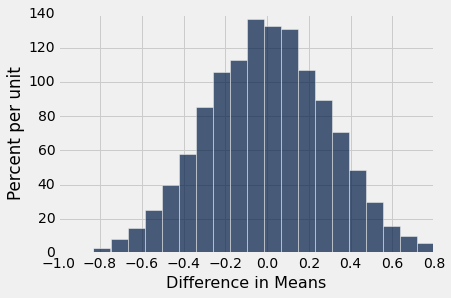

In [100]:
repetitions = 5000

test_stats = []
for i in range(repetitions):
    drops_shuffled = football.sample().column('Drop')
    patriots_shuffled = drops_shuffled[:10]
    colts_shuffled = drops_shuffled[11:]
    shuffled_difference = np.mean(patriots_shuffled) - np.mean(colts_shuffled)
    test_stats.append(shuffled_difference)
    
observation = np.mean(patriots) - np.mean(colts)
emp_p_value = np.count_nonzero(test_stats >= observation) / repetitions

differences = Table().with_column('Difference in Means', test_stats)
differences.hist(bins=20)
print("Observation:", observation)
print("Empirical P-value:", emp_p_value)

The observed difference was roughly 0.7335 psi. According to the empirical distribution above, there is a very small chance that a random permutation would yield a difference that large. So the data support the conclusion that the two groups of pressures were not like a random permutation of all 15 pressures.

The independent investiagtive team analyzed the data in several different ways, taking into account the laws of physics. The final report said, 

"[T]he average pressure drop of the Patriots game balls exceeded the average pressure drop of the Colts balls by 0.45 to 1.02 psi, depending on various possible assumptions regarding the gauges used, and assuming an initial pressure of 12.5 psi for the Patriots balls and 13.0 for the Colts balls."

-- *Investigative report commissioned by the NFL regarding the AFC Championship game on January 18, 2015*

Our analysis shows an average pressure drop of about 0.73 psi, which is consistent with the official analysis.

The all-important question in the football world was whether the excess drop of pressure in the Patriots' footballs was deliberate. To that question, the data have no answer. If you are curious about the answer given by the investigators, here is the [full report](https://nfllabor.files.wordpress.com/2015/05/investigative-and-expert-reports-re-footballs-used-during-afc-championsh.pdf).